# Financial Fraud Detection

- The objective of this notebook is to showcase the usage of the [___financial-fraud-training___ container](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/cugraph/containers/financial-fraud-training) and how to deploy the produced trained models on [NVIDIA Dynamo-Triton](https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tritonserver).
- We use [IBM TabFormer](https://github.com/IBM/TabFormer) as an example dataset and the dataset is preprocess before model training

NOTE:
* The preprocessing code is written specifically for the TabFormer dataset and will not work with other datasets.
* Additionally, a familiarity with [Jupyter](https://docs.jupyter.org/en/latest/what_is_jupyter.html) is assumed.

# Environment Setup (Sagemaker studio)
This Notebook is designed to work in a Sagemaker studio jupyter lab notebook

Please create a Conda environment and add that to the notebook - See the [README - Setup Development Environment section](../README.md) file

In [1]:
!nvidia-smi --version

NVIDIA-SMI version  : 580.95.05
NVML version        : 580.95
DRIVER version      : 580.95.05
CUDA Version        : 13.0


### Activate the env in the kernel

Now choose the `fraud_blueprint_env` kernel from within jupyterlab for this notebook

-----
## Import libraries

In [2]:
import os
import sys
import json
import time
import boto3

## Prepare the AWS Environment variables from the infrastructure stack

In [3]:
# Add the "src" directory to the search path
src_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), 'src'))
sys.path.insert(0, src_dir) 

In [4]:
from utils.aws import get_cfn_output, get_inference_host

In [5]:
ssm_client = boto3.client('ssm')
cfn_client = boto3.client('cloudformation')
elb_client = boto3.client('elbv2', region_name="us-east-1")

bucket_name = get_cfn_output("NvidiaFraudDetectionBlueprintModelExtractor", "SourceBucketName")

sagemaker_training_role = get_cfn_output("NvidiaFraudDetectionTrainingRole", "SageMakerRoleArn")

training_repo = get_cfn_output("NvidiaFraudDetectionTrainingImageRepo", "TrainingImageRepoUri")

inference_host = get_inference_host()

print(f"Bucket Name: {bucket_name}")
print(f"Training Role: {sagemaker_training_role}")
print(f"Training Repo: {training_repo}")
print(f"Inference Host: {inference_host}")

Bucket Name: ml-on-containers-541765610078
Training Role: arn:aws:iam::541765610078:role/AmazonSageMaker-ExecutionRole-CDK
Training Repo: 541765610078.dkr.ecr.us-east-1.amazonaws.com/nvidia-training-repo
Inference Host: internal-k8s-triton-tritonse-1ae517897e-1234572900.us-east-1.elb.amazonaws.com


----
# Step 1: Get and Prepare the data

## For Local
1. Download the dataset: https://ibm.ent.box.com/v/tabformer-data/folder/130747715605
2. untar and uncompreess the file: `tar -xvzf ./transactions.tgz`
3. Put card_transaction.v1.csv in in the `data/TabFormer/raw` folder


## For Brev 
1. Download the dataset: https://ibm.ent.box.com/v/tabformer-data/folder/130747715605
2. In the Jupyter notebook window, use the "File Browser" section to the data/Tabformer/raw folder
3. Drag-and-drop the "transactions.tgz" file into the folder
    - There is also an "upload" option that displays a file selector
    - Please wait for the upload to finish, it could take a while, by lookign at the status indocator at the bottom of the window
4. Now uncompress and untar by running the following command
    - Note: if somethign goes wrong you will need to delete the file rather than trying to overwrite it.

In [ ]:
# verify that the compressed file was uploaded successfully - the size should be 266M
!ls -lh ../data/TabFormer/raw

In [ ]:
# Uncompress/untar the file
!tar xvzf ../data/TabFormer/raw/transactions.tgz -C ../data/TabFormer/raw/

__If__ drag-and-drop is not working, please run the [Download TabFormer](./extra/download-tabformer.ipynb) notebook is the "extra" folder 

## Check data folder structure
The goal is to produce the following structure

```
.
    data
    └── TabFormer
        └── raw
            └── card_transaction.v1.csv
```

In [7]:
# Once the raw data is placed as described above, set the path to the TabFormer directory

# Change this path to point to TabFormer data
data_root_dir = os.path.abspath('../data/TabFormer/') 
# Change this path to the directory where you want to save your model
model_output_dir = os.path.join(data_root_dir, 'trained_models')

# Path to save the trained model
os.makedirs(model_output_dir, exist_ok=True)

### Define python function to print directory tree

In [ ]:
from utils.plotting import print_tree

In [ ]:
# Check if the raw data has been placed properly
print_tree(data_root_dir)

---
# Step 2: Preprocess the data 
- Import the Python function for preprocessing the TabFormer data
- Call `preprocess_TabFormer` function to prepare the data

NOTE: The preprocessing can takes a few minutes


In [ ]:
from data_preprocessing.raw_data_processing import load_and_clean_tabformer
from data_preprocessing.xgboost_data_generation import generate_xgboost_features
from data_preprocessing.gnn_data_generation import generate_gnn_graph_data

bundle = load_and_clean_tabformer(
    base_path=data_root_dir,              # Folder containing 'raw/card_transaction.v1.csv'
    csv_name="card_transaction.v1.csv"
)

xgb_transformer, columns_of_transformed_data = generate_xgboost_features(
    cleaned_data_bundle=bundle,
    output_dir=os.path.join(data_root_dir, "xgb"),
    data_split_year=2018)

user_mask_map, mx_mask_map, tx_mask_map = generate_gnn_graph_data(
    cleaned_data_bundle=bundle, 
    output_dir=os.path.join(data_root_dir, "gnn"),
    data_split_year=2018, 
    xgb_transformer=xgb_transformer, 
    columns_of_transformed_txs=columns_of_transformed_data)

In [ ]:
print_tree(data_root_dir)

### Graph Summary
Summarize the bipartite graph structure created by preprocessing.

  GRAPH SUMMARY: User-Merchant Transaction Network

  Graph Type: Bipartite (Users ↔ Merchants)
  Edge Type:  Transactions (with fraud labels)

  ┌─────────────────────────────────────────────────────┐
  │                   TRAINING SET                      │
  ├─────────────────────────────────────────────────────┤
  │  Users (nodes):             4,873                  │
  │  Merchants (nodes):        42,942                  │
  │  Transactions (edges):    301,524                  │
  │  Fraudulent:               27,670 (9.18%)         │
  └─────────────────────────────────────────────────────┘

  ┌─────────────────────────────────────────────────────┐
  │                     TEST SET                        │
  ├─────────────────────────────────────────────────────┤
  │  Users (nodes):             4,795                  │
  │  Merchants (nodes):         6,773                  │
  │  Transactions (edges):     25,803                  │
  │  Fraudulent:                2,087 (8.09%)      

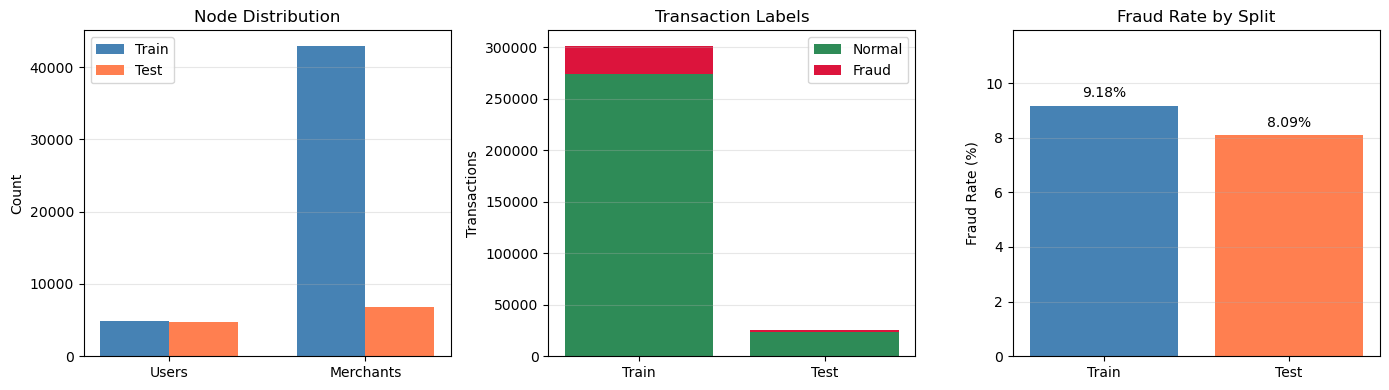

In [8]:
from utils.plotting import summarize_graph
# Run the summary
gnn_dir = os.path.join(data_root_dir, "gnn")
graph_stats = summarize_graph(gnn_dir)

In [9]:
# copy data to S3 to get pulled during training
! aws s3 sync "../data/TabFormer/" s3://$bucket_name/data/ --exclude "*/test_gnn" --force --delete

-----
# Step 3:  Now train the model using the financial-fraud-training container


## Create training configuration file
NOTE: Training configuration file must conform to schema defined in docs (to be updated.)

__Important: Models and configuration files needed for deployment using NVIDIA Dynamo-Triton will be saved in model-repository under the folder that is mounted in /trained_models inside the container__

In [10]:
import yaml

with open("../config/config.yaml", "r") as f:
    config = yaml.safe_load(f)

training_config = config["training"]

#### Save the training configuration as a json file

In [11]:
training_config_file_name = 'training_config.json'

with open(os.path.join(training_config_file_name), 'w') as json_file:
    json.dump(training_config, json_file, indent=4)

# clone config to S3
! aws s3 cp ./training_config.json s3://$bucket_name/config/training_config.json

upload: ./training_config.json to s3://ml-on-containers-541765610078/config/training_config.json


## Train model using financial_fraud_training container

In [12]:
import sys
sys.path.insert(0, '..')  # Adjust path if needed to find src/

from src.model import SageMakerTrainingJob
from src.model.sagemaker_training import SageMakerTrainingConfig

# Create configuration
config = SageMakerTrainingConfig(
    bucket_name=bucket_name,
    sagemaker_training_role=sagemaker_training_role,
    training_repo=training_repo,
    # Optional overrides (defaults shown):
    # instance_type="ml.g5.xlarge",
    # cuda_compat_version="cuda-compat-13-0",
)

# Launch training job
training_job = SageMakerTrainingJob(config)
training_job_arn = training_job.launch()

# Access job name if needed
print(f"Job name: {training_job.training_job_name}")

Training job name: fraud-detection-gnn-1765550201
Registered job name in SSM: /triton/model
Uploaded custom entrypoint to s3://ml-on-containers-541765610078/code/fraud-detection-gnn-1765550201/entrypoint.sh
Training job started: arn:aws:sagemaker:us-east-1:541765610078:training-job/fraud-detection-gnn-1765550201
Job name: fraud-detection-gnn-1765550201


#### Make sure that the training job succeeds
According to the training configuration file defined earlier, if the training runs successfully

In [13]:
final_status = training_job.poll()

Job: fraud-detection-gnn-1765550201
Status: Completed
Last checked: 2025-12-12 14:45:12


----
# Step 4:  Serve your python backend model using NVIDIA Dynamo-Triton
__!Important__: Change MODEL_REPO_PATH to point to `{model_output_dir}` / `python_backend_model_repository` if you used a different path in your training configuration file

#### Install NVIDIA Dynamo-Triton Client

In [14]:
!pip install 'tritonclient[all]' --quiet

In [15]:

from tritonclient.http import InferInput, InferRequestedOutput

In [16]:
import tritonclient.grpc as triton_grpc
import tritonclient.http as httpclient

##### Replace HOST with the actual URL where your NVIDIA Dynamo-Triton server is hosted.


In [17]:
HOST = inference_host
HTTP_PORT = 80
GRPC_PORT = 8006
METRICS_PORT = 8007

### Serve your models with NVIDIA Dynamo-Triton

With the infrastructure repo deployed, we have a Lambda function waiting for the training job to complete and for the models to be output to `s3://ml-on-containers-<accountnumber>/output` and then, they'll get extracted to a different bucket to be served by the inference host setup by our infrastructure.

### URLs for GRPC and HTTP request to the inference server

In [18]:
client_grpc = triton_grpc.InferenceServerClient(url=f'{HOST}:{GRPC_PORT}')
client_http = httpclient.InferenceServerClient(url=f'{HOST}:{HTTP_PORT}')

#### Here’s an example of how to prepare data for inference, using random data

## Prediction without computing Shapley values

### Read preprocessed input transactions to send query to NVIDIA Dynamo-Triton

In [19]:
from src.model.sagemaker_inference import prepare_and_send_inference_request, load_hetero_graph

In [20]:
import numpy as np

In [21]:
gnn_data_dir = os.path.join(data_root_dir, "gnn")
test_data = load_hetero_graph(gnn_data_dir)
compute_shap = False
result =  prepare_and_send_inference_request(
    test_data | {"COMPUTE_SHAP": np.array([compute_shap], dtype=np.bool_)},
    host=HOST,
    http_port=HTTP_PORT)

In [22]:
len(result['PREDICTION'])

25803

#### Scores on test data

In [35]:
from src.model.metrics import compute_score_for_batch, scan_thresholds

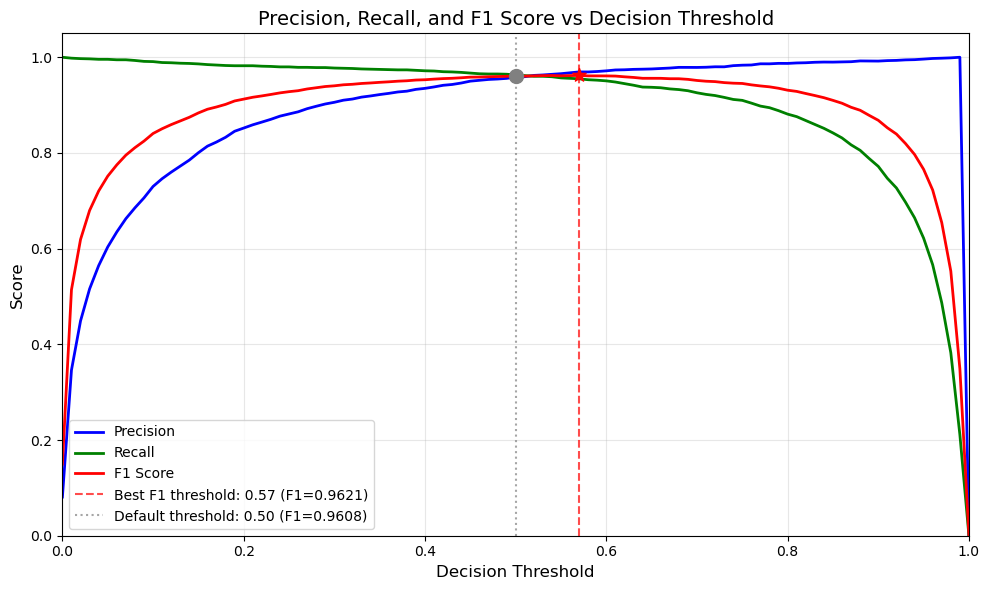


  THRESHOLD ANALYSIS SUMMARY

  Best F1 Threshold: 0.57
    - Precision: 0.9694
    - Recall:    0.9550
    - F1 Score:  0.9621

  Default Threshold (0.50):
    - Precision: 0.9585
    - Recall:    0.9631
    - F1 Score:  0.9608

  F1 Improvement: 0.0013 (0.14%)


In [36]:
y = test_data['edge_label_user_to_merchant'].to_numpy(dtype=np.int32)
threshold_results = scan_thresholds(y, result['PREDICTION'], step=0.01)

                 Predicted      
                 Non-Fraud Fraud
Actual Non-Fraud     23653    63
       Fraud            94  1993


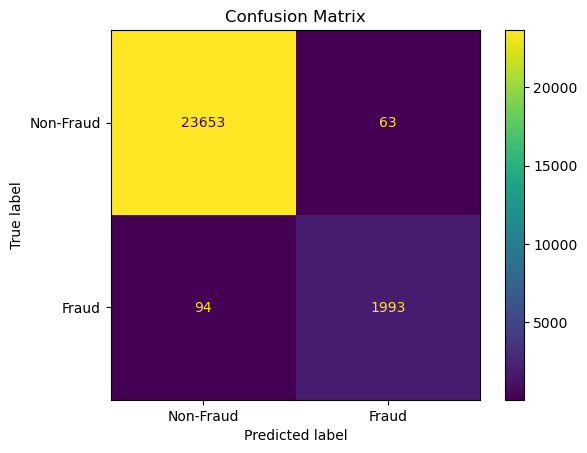

----Summary---
Accuracy:  0.9939
Precision: 0.9694
Recall:    0.9550
F1 Score:  0.9621


In [37]:
# Decision threshold to flag a transaction as fraud
# Change to trade-off precision and recall
decision_threshold = threshold_results['best_threshold']
compute_score_for_batch(y, result['PREDICTION'], decision_threshold)

---
# Step 5: Latency and Throughput Tests

Measure inference performance with **realistic request sizes**:
- **Single transaction**: 1 edge + connected user/merchant (real-time fraud scoring)
- **Small batch**: 10-100 transactions (micro-batch processing)
- **Varying batch sizes**: Latency scaling analysis

### Create Realistic Test Samples
Generate subgraphs of varying sizes to simulate real-world request patterns.

In [38]:
from src.utils.plotting import create_batch_samples, print_subgraph_stats

In [39]:
# Load full test data
full_test_data = load_hetero_graph(gnn_data_dir)

# Create samples for different batch sizes
batch_sizes = [1, 10, 50, 100]
num_samples_per_size = 500  # Number of samples to create for each batch size

test_samples = {}
for batch_size in batch_sizes:
    samples = create_batch_samples(full_test_data, batch_size, num_samples_per_size, gnn_data_dir)
    test_samples[batch_size] = samples
    print_subgraph_stats(samples[0], f"Batch size {batch_size} (example)")

print(f"\nCreated {num_samples_per_size} samples for each batch size: {batch_sizes}")

Batch size 1 (example): 1 transactions, 1 users, 1 merchants
Batch size 10 (example): 10 transactions, 10 users, 9 merchants
Batch size 50 (example): 50 transactions, 50 users, 47 merchants
Batch size 100 (example): 100 transactions, 99 users, 82 merchants

Created 500 samples for each batch size: [1, 10, 50, 100]


### Single Transaction Latency (Real-time Fraud Scoring)
This is the most critical metric: how fast can we score a single incoming transaction?

In [40]:
from src.model.metrics import measure_latency_for_samples, print_latency_stats

In [41]:
# Measure single transaction latency (batch_size=1)
print("Measuring SINGLE TRANSACTION latency (batch_size=1)...")
single_tx_latencies = measure_latency_for_samples(
    test_samples[1],
    compute_shap=False,
    host=inference_host,
    http_port=HTTP_PORT)

print_latency_stats(single_tx_latencies, "Single Transaction Latency (without SHAP)")

Measuring SINGLE TRANSACTION latency (batch_size=1)...
  Completed 100/500 requests...
  Completed 200/500 requests...
  Completed 300/500 requests...
  Completed 400/500 requests...
  Completed 500/500 requests...

  Single Transaction Latency (without SHAP)
  Requests:    500
  Mean:           25.40 ms
  Std Dev:         0.77 ms
  Min:            24.06 ms
  Max:            32.79 ms
  P50:            25.27 ms
  P90:            26.04 ms
  P95:            26.59 ms
  P99:            28.90 ms


### Latency vs Batch Size
How does latency scale as we increase the number of transactions per request?

In [42]:
# Measure latency for different batch sizes
latency_by_batch_size = {}

for batch_size in batch_sizes:
    print(f"\nMeasuring latency for batch_size={batch_size}...")
    latencies = measure_latency_for_samples(
        test_samples[batch_size],
        compute_shap=False,
        host=inference_host,
        http_port=HTTP_PORT)
    latency_by_batch_size[batch_size] = latencies
    print_latency_stats(latencies, f"Batch Size = {batch_size} transactions")


Measuring latency for batch_size=1...
  Completed 100/500 requests...
  Completed 200/500 requests...
  Completed 300/500 requests...
  Completed 400/500 requests...
  Completed 500/500 requests...

  Batch Size = 1 transactions
  Requests:    500
  Mean:           25.81 ms
  Std Dev:         2.42 ms
  Min:            24.31 ms
  Max:            63.68 ms
  P50:            25.42 ms
  P90:            26.60 ms
  P95:            27.43 ms
  P99:            31.59 ms

Measuring latency for batch_size=10...
  Completed 100/500 requests...
  Completed 200/500 requests...
  Completed 300/500 requests...
  Completed 400/500 requests...
  Completed 500/500 requests...

  Batch Size = 10 transactions
  Requests:    500
  Mean:           26.64 ms
  Std Dev:         0.77 ms
  Min:            25.25 ms
  Max:            31.65 ms
  P50:            26.49 ms
  P90:            27.46 ms
  P95:            27.96 ms
  P99:            29.96 ms

Measuring latency for batch_size=50...
  Completed 100/500 requests

### Throughput Test (Concurrent Single-Transaction Requests)
Simulate multiple users submitting transactions simultaneously.

In [43]:
from src.model.metrics import measure_throughput

In [44]:
# Test throughput with different concurrency levels using single-transaction requests
concurrency_levels = [1, 5, 10, 20]
throughput_results = {}

for num_workers in concurrency_levels:
    throughput, _ = measure_throughput(
        test_samples[1],
        num_workers=num_workers,
        compute_shap=False,
        host=inference_host,
        http_port=HTTP_PORT)
    throughput_results[num_workers] = throughput
    print()

Running throughput test: 500 requests, 1 concurrent workers...

  Throughput Test Results (1 workers)
  Total requests:     500
  Successful:         500
  Errors:             0
  Total time:         13.06 s
  Throughput:         38.27 tx/s
  Avg latency:        26.07 ms
  P95 latency:        27.47 ms

Running throughput test: 500 requests, 5 concurrent workers...

  Throughput Test Results (5 workers)
  Total requests:     500
  Successful:         500
  Errors:             0
  Total time:         11.39 s
  Throughput:         43.91 tx/s
  Avg latency:        113.33 ms
  P95 latency:        117.41 ms

Running throughput test: 500 requests, 10 concurrent workers...

  Throughput Test Results (10 workers)
  Total requests:     500
  Successful:         500
  Errors:             0
  Total time:         11.39 s
  Throughput:         43.90 tx/s
  Avg latency:        225.60 ms
  P95 latency:        231.98 ms

Running throughput test: 500 requests, 20 concurrent workers...

  Throughput Test

### Visualizations

/tmp/ipykernel_7502/1551163658.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(batch_data, labels=[str(bs) for bs in batch_sizes], patch_artist=True)


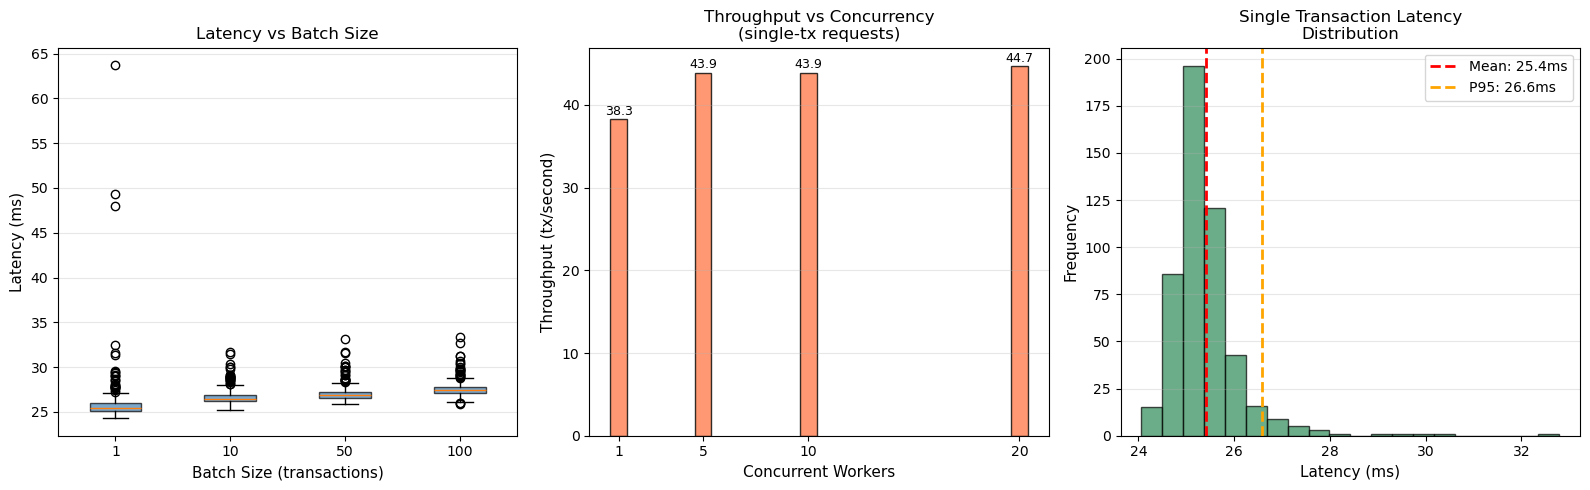

In [45]:
import matplotlib.pyplot as plt
import statistics

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Latency vs Batch Size (box plot)
ax1 = axes[0]
batch_data = [latency_by_batch_size[bs] for bs in batch_sizes]
bp = ax1.boxplot(batch_data, labels=[str(bs) for bs in batch_sizes], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('steelblue')
    patch.set_alpha(0.7)
ax1.set_xlabel('Batch Size (transactions)', fontsize=11)
ax1.set_ylabel('Latency (ms)', fontsize=11)
ax1.set_title('Latency vs Batch Size', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# 2. Throughput vs Concurrency
ax2 = axes[1]
workers = list(throughput_results.keys())
throughputs = list(throughput_results.values())
bars = ax2.bar(workers, throughputs, color='coral', edgecolor='black', alpha=0.8)
ax2.set_xlabel('Concurrent Workers', fontsize=11)
ax2.set_ylabel('Throughput (tx/second)', fontsize=11)
ax2.set_title('Throughput vs Concurrency\n(single-tx requests)', fontsize=12)
ax2.set_xticks(workers)
for bar, t in zip(bars, throughputs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{t:.1f}', ha='center', fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# 3. Single Transaction Latency Distribution
ax3 = axes[2]
ax3.hist(single_tx_latencies, bins=20, color='seagreen', edgecolor='black', alpha=0.7)
mean_lat = statistics.mean(single_tx_latencies)
p95_lat = sorted(single_tx_latencies)[int(len(single_tx_latencies) * 0.95)]
ax3.axvline(mean_lat, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_lat:.1f}ms')
ax3.axvline(p95_lat, color='orange', linestyle='--', linewidth=2, label=f'P95: {p95_lat:.1f}ms')
ax3.set_xlabel('Latency (ms)', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Single Transaction Latency\nDistribution', fontsize=12)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Summary Table

In [46]:
# Build summary table comparing latency across batch sizes
import pandas as pd

summary_rows = []
for batch_size in batch_sizes:
    lats = latency_by_batch_size[batch_size]
    lats_sorted = sorted(lats)
    n = len(lats)
    summary_rows.append({
        'Batch Size': batch_size,
        'Mean (ms)': f"{statistics.mean(lats):.2f}",
        'P50 (ms)': f"{lats_sorted[int(n * 0.50)]:.2f}",
        'P95 (ms)': f"{lats_sorted[int(n * 0.95)]:.2f}",
        'P99 (ms)': f"{lats_sorted[min(int(n * 0.99), n-1)]:.2f}",
        'Min (ms)': f"{min(lats):.2f}",
        'Max (ms)': f"{max(lats):.2f}",
        'Latency/Tx (ms)': f"{statistics.mean(lats) / batch_size:.2f}"
    })

summary_df = pd.DataFrame(summary_rows)
summary_df.set_index('Batch Size', inplace=True)

print("\n" + "="*70)
print("  LATENCY SUMMARY BY BATCH SIZE")
print("="*70)
display(summary_df)

# Key insights
single_tx_mean = statistics.mean(latency_by_batch_size[1])
batch_100_mean = statistics.mean(latency_by_batch_size[100])
print(f"\nKey Insights:")
print(f"  - Single transaction P95 latency: {sorted(latency_by_batch_size[1])[int(len(latency_by_batch_size[1]) * 0.95)]:.2f} ms")
print(f"  - Batching 100 tx reduces per-tx latency by {(1 - (batch_100_mean/100) / single_tx_mean) * 100:.1f}%")
print(f"  - Max throughput (20 workers): {throughput_results.get(20, 'N/A'):.1f} tx/s" if 20 in throughput_results else "")


  LATENCY SUMMARY BY BATCH SIZE


,Mean (ms),P50 (ms),P95 (ms),P99 (ms),Min (ms),Max (ms),Latency/Tx (ms)
Batch Size,,,,,,,
1,25.81,25.42,27.43,31.59,24.31,63.68,25.81
10,26.64,26.49,27.96,29.96,25.25,31.65,2.66
50,27.01,26.88,28.17,30.14,25.85,33.14,0.54
100,27.50,27.42,28.72,30.65,25.86,33.33,0.28



Key Insights:
  - Single transaction P95 latency: 27.43 ms
  - Batching 100 tx reduces per-tx latency by 98.9%
  - Max throughput (20 workers): 44.7 tx/s
